In [1]:

import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import pmdarima as pm
%matplotlib inline
import matplotlib
matplotlib.use('Agg') 
import pandas as pd
import numpy as np
import utils
#from utils import reduce_memory_usage
from utils import break_datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import joblib
import zipfile
import os
import category_encoders
from sklearn.preprocessing import StandardScaler
import joblib
import zipfile
import os
import holidays
import wandb

warnings.filterwarnings('ignore')

# Specify the ZIP file name
zip_filename = "../dataset/filtered.zip"

# Extract the model file from the ZIP archive
with zipfile.ZipFile(zip_filename, "r") as archive:
    # Extract the model file (named "your_model.pkl" in this example)
    archive.extract("filtered.pkl")
    
# Load the model
df = joblib.load("filtered.pkl")  # Replace with "pickle.load" if you used pickle

os.remove("filtered.pkl")

def break_datetime(df):
    df['timestamp']= pd.to_datetime(df['timestamp'])
    df[['year','weekofyear','dayofweek']]= np.uint16(df['timestamp'].dt.isocalendar())
    df['month']= np.uint8(df['timestamp'].dt.month)
    df['hour']= np.uint8(df['timestamp'].dt.hour)
    return df

def percent_missing_val(df):

  percent_missing = (df.isnull().sum() * 600) / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
  return missing_value_df

def nan_fillers(df):
  air_temp_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['air_temperature'].transform('mean')
  df['air_temperature'].fillna(air_temp_df, inplace=True)

  dew_temp_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['dew_temperature'].transform('mean')
  df['dew_temperature'].fillna(dew_temp_df, inplace=True)

  cloud_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['cloud_coverage'].transform('mean')
  df['cloud_coverage'].fillna(cloud_df, inplace=True)

  sea_level_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['sea_level_pressure'].transform('mean')
  df['sea_level_pressure'].fillna(sea_level_df, inplace=True)

  precip_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['precip_depth_1_hr'].transform('mean')
  df['precip_depth_1_hr'].fillna(precip_df, inplace=True)

  wind_dir_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['wind_direction'].transform('mean')
  df['wind_direction'].fillna(wind_dir_df, inplace=True)

  wind_speed_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['wind_speed'].transform('mean')
  df['wind_speed'].fillna(wind_speed_df, inplace=True)


  return df

def circular_encode(feature, max_value):
    sin_encoded = np.sin(2 * np.pi * feature / max_value)
    cos_encoded = np.cos(2 * np.pi * feature / max_value)
    return sin_encoded, cos_encoded,

df = df[df['site_id'].isin([1, 6])]
df['log_meter_reading']=np.log1p(df['meter_reading'])
df['log_square_feet']=np.log1p(df['square_feet'])
df= break_datetime(df)
df.drop(['year_built', 'floor_count'], axis=1,inplace=True)
df= nan_fillers(df)
df['cloud_coverage'].fillna(df['cloud_coverage'].median(), inplace=True)
df['sea_level_pressure'].fillna(df['sea_level_pressure'].median(), inplace=True)
df['precip_depth_1_hr'].fillna(df['precip_depth_1_hr'].median(), inplace=True)
df=df.sort_values(by='timestamp')
df['month_sin'], df['month_cos'] = circular_encode(df['month'], 12)
df['hour_sin'], df['hour_cos'] = circular_encode(df['hour'], 24)
df['dayofweek_sin'], df['dayofweek_cos'] = circular_encode(df['dayofweek'], 7)
label_enc= LabelEncoder()
label_enc.fit(df['primary_use'])
df['primary_use_encoded'] = label_enc.transform(df['primary_use'])
df['is_weekday']=df['dayofweek'] <= 5

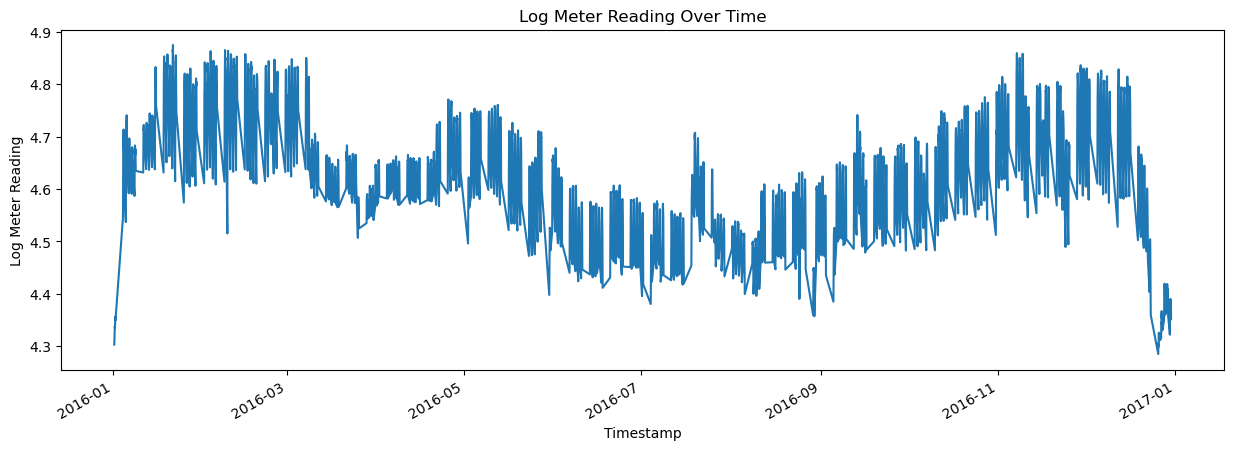

In [2]:

%matplotlib inline
series=df[['timestamp','log_meter_reading']]
series=series.groupby('timestamp')['log_meter_reading'].mean()
#Plot 'log_meter_reading' against 'timestamp'
plt.figure(figsize=(15, 5))
series.plot()

plt.xlabel('Timestamp')
plt.ylabel('Log Meter Reading')
plt.title('Log Meter Reading Over Time') 
plt.show()

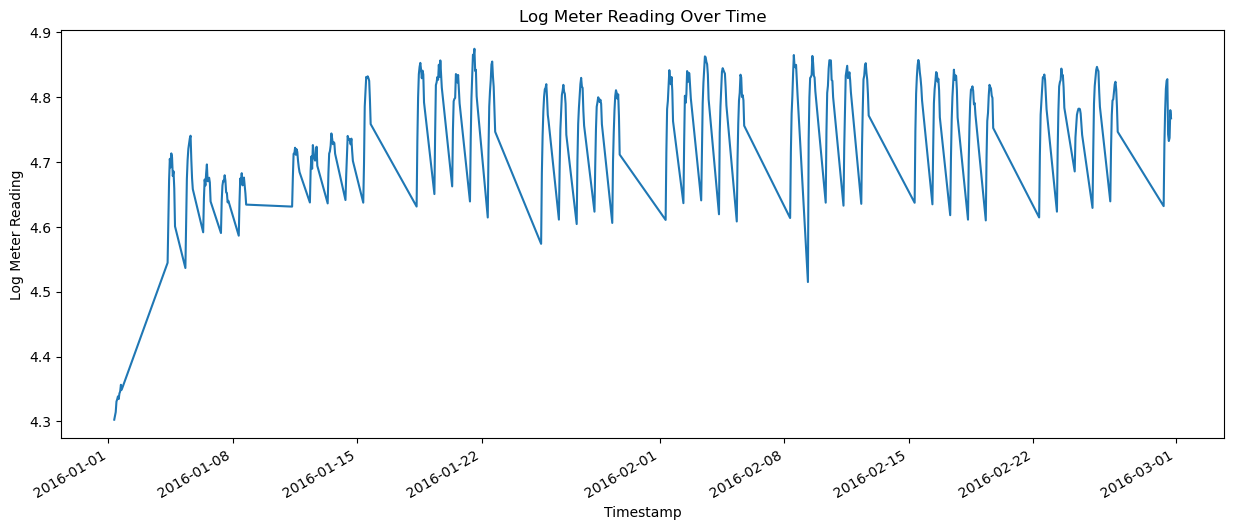

In [28]:
%matplotlib inline
series2=df[df['timestamp']<'2016-03-01'][['timestamp','log_meter_reading']]
series2=series2.groupby('timestamp')['log_meter_reading'].mean()
#Plot 'log_meter_reading' against 'timestamp'
plt.figure(figsize=(15, 6))
series2.plot()

plt.xlabel('Timestamp')
plt.ylabel('Log Meter Reading')
plt.title('Log Meter Reading Over Time') 
plt.show()

In [3]:
dataframe=pd.DataFrame(series).reset_index()
dataframe.head()

,timestamp,log_meter_reading
0,2016-01-01 08:00:00,4.302807
1,2016-01-01 09:00:00,4.309054
2,2016-01-01 10:00:00,4.314555
3,2016-01-01 11:00:00,4.330748
4,2016-01-01 12:00:00,4.334239


<Figure size 600x300 with 0 Axes>

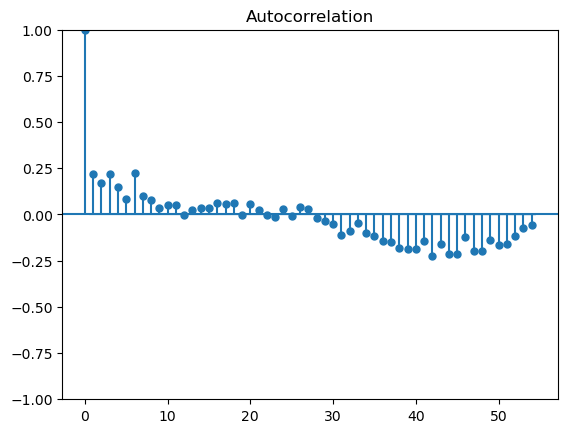

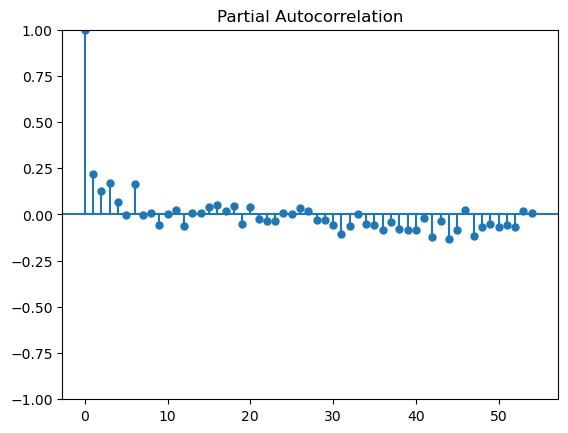

In [4]:
#ARIMA Model
#Is time series stationary
#ACF: How well the current observation correlates with past observations (t and t-2)
#PACF: t and t-1

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(6, 3))
acf_original=plot_acf(df['log_meter_reading'])
pacf_original=plot_pacf(df['log_meter_reading'])
plt.show()


<Figure size 2000x1000 with 0 Axes>

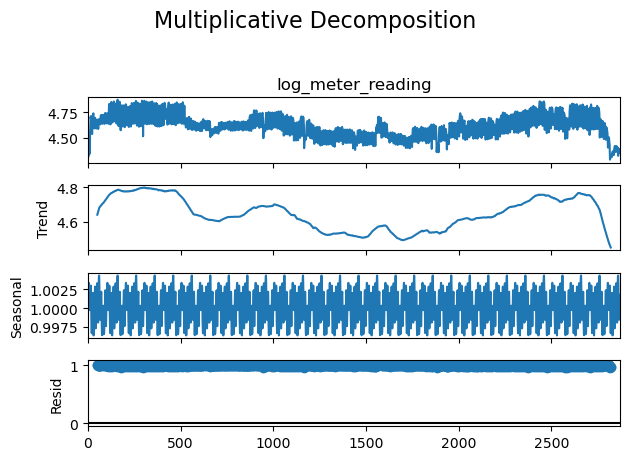

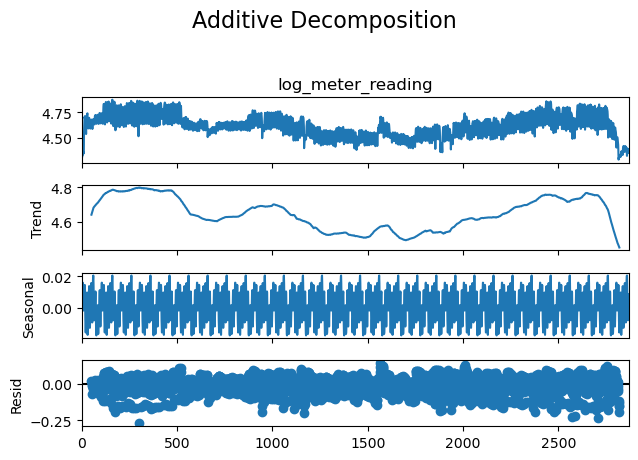

In [5]:

multiplicative_decomposition = seasonal_decompose(dataframe['log_meter_reading'], model='multiplicative', period=100)

# Additive Decomposition
additive_decomposition = seasonal_decompose(dataframe['log_meter_reading'], model='additive', period=100)
# Plot
plt.figure(figsize=(20, 10))
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

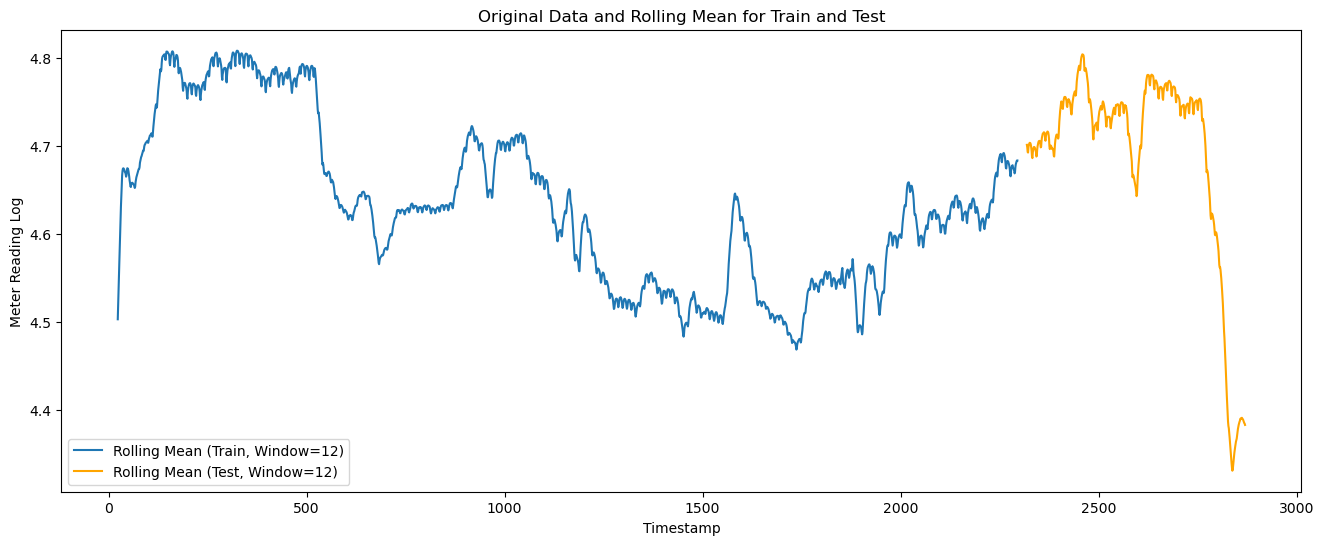

In [16]:
#ARIMA

# Set 'timestamp' as the index
#dataframe.set_index('timestamp', inplace=True)

train_size = int(len(dataframe) * 0.8)
train, test = dataframe.iloc[:train_size], dataframe.iloc[train_size:]

rolling_mean_train = train['log_meter_reading'].rolling(window=24).mean()
rolling_mean_test = test['log_meter_reading'].rolling(window=24).mean()


# Fit ARIMA model
order = (0, 0, 1)  # Adjust the order based on your data, as data stationary
arima_model = ARIMA(train['log_meter_reading'], order=order)
fitted_model = arima_model.fit()
predictions_train = fitted_model.predict(start=0, end=len(train)-1)
predictions_test = fitted_model.predict(start=len(train), end=len(dataframe)-1)

plt.figure(figsize=(16, 6))
#plt.plot(train.index, train['meter_reading_log'], label='Train', color='blue')
plt.plot(rolling_mean_train.index, rolling_mean_train, label='Rolling Mean (Train, Window=12)')

#plt.plot(test.index, test['meter_reading_log'], label='Test', color='green')
plt.plot(rolling_mean_test.index, rolling_mean_test, label='Rolling Mean (Test, Window=12)', color='orange')
plt.title('Original Data and Rolling Mean for Train and Test')
plt.xlabel('Timestamp')
plt.ylabel('Meter Reading Log')
plt.legend()
plt.show()

In [17]:
dataframe

,timestamp,log_meter_reading
0,2016-01-01 08:00:00,4.302807
1,2016-01-01 09:00:00,4.309054
2,2016-01-01 10:00:00,4.314555
3,2016-01-01 11:00:00,4.330748
4,2016-01-01 12:00:00,4.334239
...,...,...
2866,2016-12-30 14:00:00,4.389117
2867,2016-12-30 15:00:00,4.385987
2868,2016-12-30 16:00:00,4.372048
2869,2016-12-30 17:00:00,4.386491


In [12]:
target = ['log_meter_reading']
y_train = train[target]
y_test = test[target]
X_train = train.drop(target, axis=1)
X_test = test.drop(target, axis=1)

In [18]:
# Calculate metrics for training data
mae_train = mean_absolute_error(train['log_meter_reading'], predictions_train)
mse_train = mean_squared_error(train['log_meter_reading'], predictions_train)
r2_train = r2_score(train['log_meter_reading'], predictions_train)

# Calculate metrics for test data
mae_test = mean_absolute_error(test['log_meter_reading'], predictions_test)
mse_test = mean_squared_error(test['log_meter_reading'], predictions_test)
r2_test = r2_score(test['log_meter_reading'], predictions_test)

print(f"MAE (Training): {mae_train}")
print(f"MSE (Training): {mse_train}")
print(f"R-squared (Training): {r2_train}")
print("\n")
print(f"MAE (Test): {mae_test}")
print(f"MSE (Test): {mse_test}")
print(f"R-squared (Test): {r2_test}")

MAE (Training): 0.050765958158925345
MSE (Training): 0.00424901207799179
R-squared (Training): 0.6311697238614137


MAE (Test): 0.1262884736931435
MSE (Test): 0.021083168208189368
R-squared (Test): -0.15823597836229952


In [21]:
#Grid Search
import itertools
import statsmodels.api as sm

# Split the data into training and testing sets
train_size = int(len(dataframe) * 0.8)
train, test = dataframe.iloc[:train_size], dataframe.iloc[train_size:]

p_value=range(0,5)
q_value=range(0,5)

best_mse=mse
best_order=None

for p,q in itertools.product(p_value,q_value):
    order=(p,0,q)
    arima_model=sm.tsa.ARIMA(train['log_meter_reading'], order=order)
    fitted_model=arima_model.fit()

    predictions_train=fitted_model.predict(start=0, end=len(test)-1)
    mse=mean_squared_error(test['log_meter_reading'], predictions)

    if mse<best_mse:
        best_mse=mse
        best_order=order
                
print(f"Best order:{best_order}, Best MSE: {best_mse}")

In [ ]:
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:      log_meter_reading   No. Observations:                 7008
Model:                 ARIMA(0, 1, 5)   Log Likelihood               -1247.470
Date:                Thu, 30 Nov 2023   AIC                           2506.940
Time:                        19:29:54   BIC                           2548.068
Sample:                    01-01-2016   HQIC                          2521.111
                         - 10-18-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9841      0.021    -47.257      0.000      -1.025      -0.943
ma.L2         -0.0245      0.017     -1.454      0.146      -0.058       0.009
ma.L3          0.0104      0.017      0.622      0.5

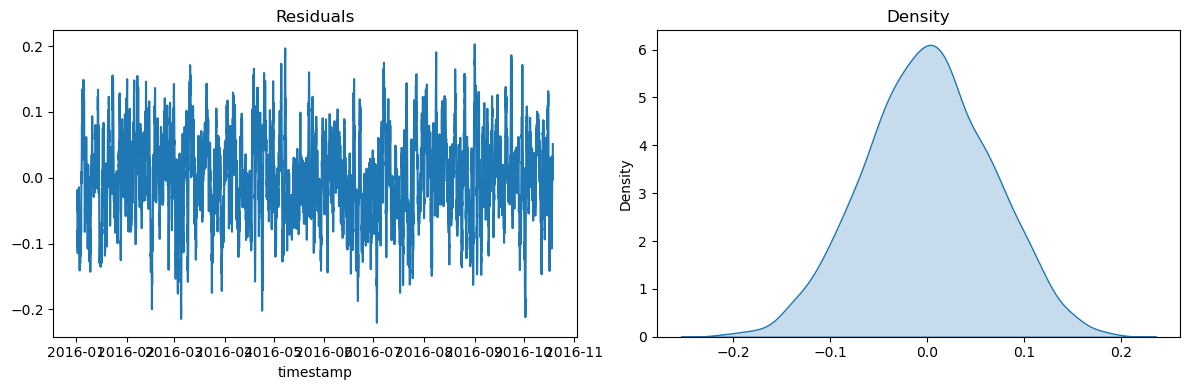

In [ ]:
residuals = fitted_model.resid[1:].rolling(window=20).mean()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figsize as needed

# Plot residuals
sns.lineplot(x=residuals.index.get_level_values("timestamp"), y=residuals, ax=ax[0])
ax[0].set_title('Residuals')

# Plot density
sns.kdeplot(residuals.dropna(), ax=ax[1], fill=True)
ax[1].set_title('Density')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()



In [1]:
import pmdarima as pm
auto_arima=pm.auto_arima(train_6, stepwise=False, seasonal=False)
auto_arima

NameError: name 'train_6' is not defined

In [ ]:
!pip install wandb --upgrade